## Read and plot the ensemble stats coming from the OCCIPUT 50xJason2-like SLA database

* This notebook aims at demonstrating how to open, read and plot the files shared on the MEOM opendap containing the ensemble statistiques from the the OCCIPUT 50xJason2-like SLA database.

* You can either download the files here from :

```wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ORCA025.L75-OCCITENS-S/OBS-SLA/STATS/QUA50ERROBSrmTM.tar``` and then ```tar -xf QUA50ERROBSrmTM.tar````.

* Or even more conveniently you can use the python module ```pydap``` and read the files __directly from the opendap__ as demonstrated below.

* You can also have a look at the other notebook ('readRANKS') that demonstrates how to read across all files and compute an avergae.

* Questions? : stephanie.leroux@ocean-next.fr


# Module imports

In [17]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# to read files directly from opendap
from pydap.client import open_url

# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from jdcal import gcal2jd, jd2gcal

%matplotlib inline 

# Define some functions for plot purposes

In [74]:
def plotmapSCATT(fig1,ehonan,nav_lon,nav_lat,cm_base,vmin,vmax,Nincr,plto,glo=True,coastL=False,coastC=False,xlim=(0,10),ylim=(0,10),su='b',so='k',loncentr=0.,outonly=False, inonly=False):
        '''
        
        Plot regional or global map of scatter data (point by point data).
        Uses Cartopy.
        Parameters: (... description of the different parameters to to...)

        '''
        
        ## imports
        import os,sys
        import numpy as np

        # xarray
        import xarray as xr

        # plot
        import cartopy.crs as ccrs
        import cartopy.feature as ccf
        import matplotlib.pyplot as plt
        from matplotlib.colors import Colormap
        import matplotlib.colors as mcolors
        import matplotlib.dates as mdates
        import matplotlib.cm as cm
        import matplotlib.dates as mdates
        import matplotlib.ticker as mticker
        
        # Colormap & levels
        cmap = plt.get_cmap(cm_base)
        cmap.set_under(su,1.)
        cmap.set_over(so,1.) 
        levels = mticker.MaxNLocator(nbins=Nincr).tick_values(vmin, vmax)
        norm   = mcolors.BoundaryNorm(levels, ncolors=cmap.N)
        
        # Projection
        
        trdata  = ccrs.PlateCarree() 
        # Note: if data points are given in classical lat lon coordinates this should
        #       be set to ccrs.PlateCarree() whatever the map projection is.
        
        if glo:
            ax = plt.axes(projection=ccrs.Robinson(central_longitude=loncentr))
            # marker size
            sm=0.1
        else:
            ax = plt.axes(projection= ccrs.PlateCarree())
            # marker size
            sm=0.5
        
        if glo:
            ax.set_global() 
            
        if glo:
            ax.outline_patch.set_edgecolor('#585858')
        else:
            ax.outline_patch.set_edgecolor('white')
            

        # grid on map
        if glo:
            gl = ax.gridlines(linewidth=1, color='#585858', alpha=0.2, linestyle='--') 
        else:
            gl = ax.gridlines(draw_labels=True,linewidth=1, color='#585858', alpha=0.2, linestyle='--')
            # grid labels
            label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}
            gl.xlabel_style = label_style
            gl.xlabels_bottom = False
            gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20,dtype=float))
            gl.ylabel_style = label_style
            gl.ylabels_right = False
            gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20,dtype=float))
       
        # Add Coastlines and or plain continents
        if coastC:
            ax.add_feature(ccf.LAND, facecolor='#585858', edgecolor='none')
        if coastL:
            ax.coastlines(color='#585858')
        
        ### PLOTS:
        
        if inonly==False:
            # plot points where rank is 0
            cs2 = plt.scatter(nav_lon.where(ehonan==0.), nav_lat.where(ehonan==0.), s=sm, marker="D",color=su,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            # plot points where rank is 1
            cs3 = plt.scatter(nav_lon.where(ehonan==1.), nav_lat.where(ehonan==1.), s=sm,  marker="D",color=so,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            # plot points where rank is different from 0 and 1 (true obs in the model pdf)
        
        if outonly==False:
            cs = plt.scatter(nav_lon.where((ehonan!=1.)&(ehonan!=0.)), nav_lat.where((ehonan!=1.)&(ehonan!=0.)), s=sm, marker="D", c=ehonan.where((ehonan!=1.)&(ehonan!=0.)), cmap=cmap,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            #cs = plt.scatter(nav_lon, nav_lat, s=sm, marker="D", c=ehonan, cmap=cmap,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
        
        if glo==False:
            #limits
            plt.xlim(xlim)
            plt.ylim(ylim) 

        # plot colorbar
        cb = plt.colorbar(cs, extend='both',  pad=0.04, orientation='horizontal', shrink=0.75)
        cb.ax.tick_params(labelsize=15) 
        cb.set_label(labelplt,size=15)
        ticks = np.linspace(vmin,vmax,11)
        cb.set_ticks(ticks)
        new_tickslabels = ["%.2f" % i for i in ticks]
        cb.set_ticklabels(new_tickslabels)

# Some parameters

In [14]:
# opendap url:
baseurl = 'https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/dodsC/meomopendap/extract/ORCA025.L75-OCCITENS-S/OBS-SLA/STATS/'

# directory where to save plots
diro='./plots/'

# name of variable in .cobs files (from Sesam)
varna='JASON'

# TIME coordinate:
# cnes reference julian date 
cnesjdref = 2433282.5 
# will use package jdcal to convert julian days to dates


# unit to appear in plot title
unitna = 'm'

# output res and format
dpifig=150
pltty = ".png"

## Read quantiles for a given time segment 

* The time segment corresponds to a satellite cyle of 10 days)

* Note that the example script below will read files directly from the opendap

In [27]:
# Example time segment to read
seg =  21560 
# convert time segment in a calendar date
DATE     = jd2gcal(seg+4,cnesjdref)
# note: +4 is  by convention to set the date to the middle of the 10d period 

datena= str(DATE[0])+'-'+str(DATE[1])+'-'+str(DATE[2])
print('---'+str(seg))
print(datena)


# WILL READ THE DATASET DIRECTLY FROM THE OPENDAP
# name of input directory (directly from the opendap)
namdir      = 'QUA50ERROBSrmTM_'+str(seg)+'_0011.cobs.bas/'
fili1       = 'vctJASON0011.cobs'
path2file1  = baseurl+namdir+fili1

# read corresponding lat, lon and ranks
lon       = xr.open_dataset(path2file1)['lon'] 
lat       = xr.open_dataset(path2file1)['lat'] 

# read all deciles and concatenate in the same xarray
for iq in range(1,12):
    if iq<10:
        path2file = baseurl+namdir+'vctJASON000'+str(iq)+'.cobs'
    else:
        path2file = baseurl+namdir+'vctJASON00'+str(iq)+'.cobs'
    # read
    quantile = xr.open_dataset(path2file)[varna] 
    # concatenate
    if iq>1:
        allquantiles = xr.concat([allquantiles,quantile],dim='q')
    else: 
        allquantiles = quantile

# assign coordinate values for q quantiles: here from 0 to 1 by 0.1.
allquantiles = allquantiles.assign_coords(q=np.arange(0,1.1,0.1))

---21560
2009-1-15


# Plot regional map of the median value for that given time:

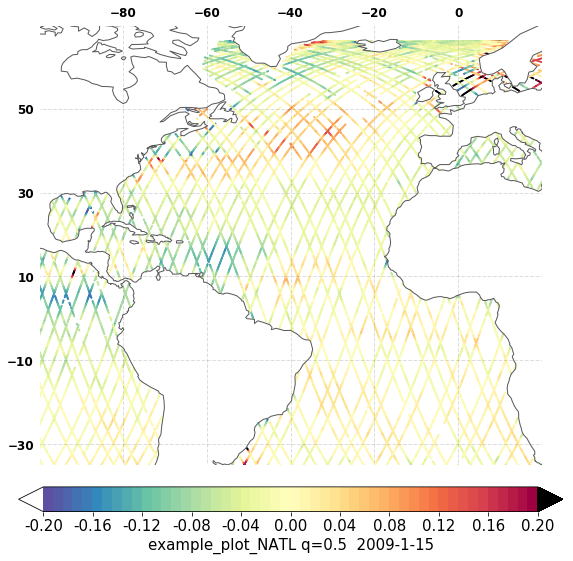

In [59]:
# select median values 
iqselect = 0.5
selectq = allquantiles.sel(q=iqselect)


#------ PLOT PARAMETERS ---------------
# colormap
cm_base='Spectral_r'  

# min/max values
vmin=-0.2
vmax=0.2
Nincr=50

# central longitude (for global map)
loncentr=180

# data to plot: 
# note: (before plotting we exclude the artefact values great/smaller than 10/-10 du to a problem in the files (coming from when the time-mean was removed))
data2plot = selectq.where((selectq<10.)&(selectq>-10.)).squeeze()

# plot title and output file title
plti="example_plot_NATL"
labelplt= plti+' q='+str(iqselect)+' '+' '+datena
plto = "NATL_SLA."+plti+'_'+str(DATE[0])


#create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon,lat,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=False,coastL=True,coastC=False,su='w',so='k',inonly=True) #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  

# Plot global map of min and max values for that given time

## Min:

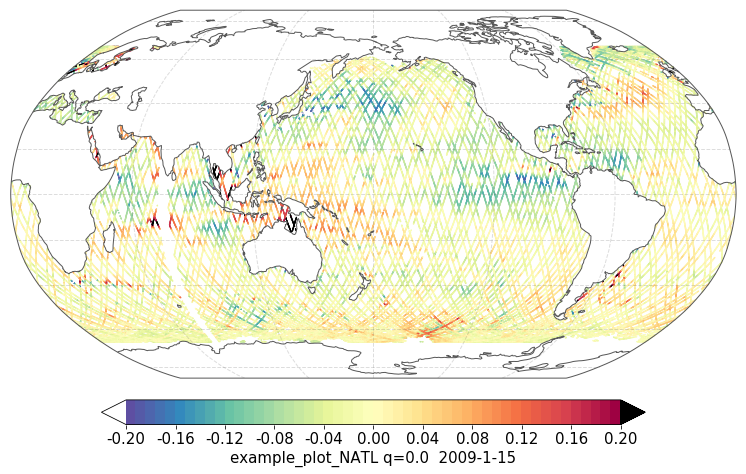

In [61]:
# select min values 
iqselect = 0.0
selectq = allquantiles.sel(q=iqselect)


#------ PLOT PARAMETERS ---------------
# colormap
cm_base='Spectral_r'  

# min/max values
vmin=-0.2
vmax=0.2
Nincr=50

# central longitude (for global map)
loncentr=180

# data to plot: 
# note: (before plotting we exclude the artefact values great/smaller than 10/-10 du to a problem in the files (coming from when the time-mean was removed))
data2plot = selectq.where((selectq<10.)&(selectq>-10.)).squeeze()

# plot title and output file title
plti="example_plot_GLO"
labelplt= plti+' q='+str(iqselect)+' '+' '+datena
plto = "GLO_SLA."+plti+'_'+str(DATE[0])


#create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon,lat,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=True,loncentr=loncentr,coastL=True,coastC=False,su='w',so='k',inonly=True) #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  

## Max:

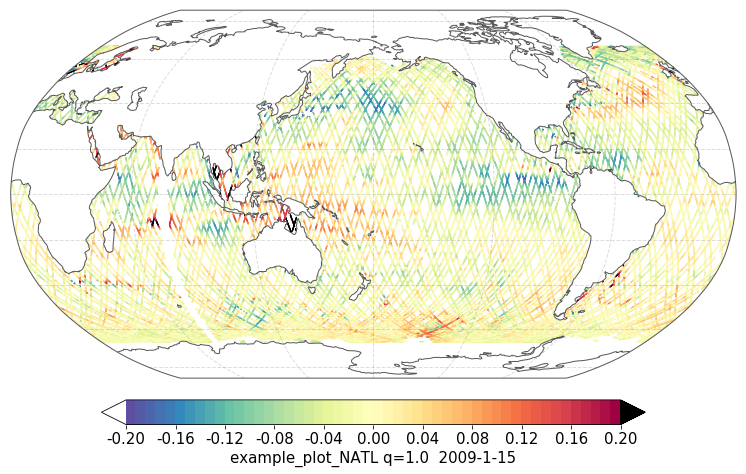

In [62]:
# select max values 
iqselect = 1.0
selectq = allquantiles.sel(q=iqselect)


#------ PLOT PARAMETERS ---------------
# colormap
cm_base='Spectral_r'  

# min/max values
vmin=-0.2
vmax=0.2
Nincr=50

# central longitude (for global map)
loncentr=180

# data to plot: 
# note: (before plotting we exclude the artefact values great/smaller than 10/-10 du to a problem in the files (coming from when the time-mean was removed))
data2plot = selectq.where((selectq<10.)&(selectq>-10.)).squeeze()

# plot title and output file title
plti="example_plot_GLO"
labelplt= plti+' q='+str(iqselect)+' '+' '+datena
plto = "GLO_SLA."+plti+'_'+str(DATE[0])


#create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon,lat,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=True,loncentr=loncentr,coastL=True,coastC=False,su='w',so='k',inonly=True) #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  

# Plot regional map of the (max-min) difference for that given time

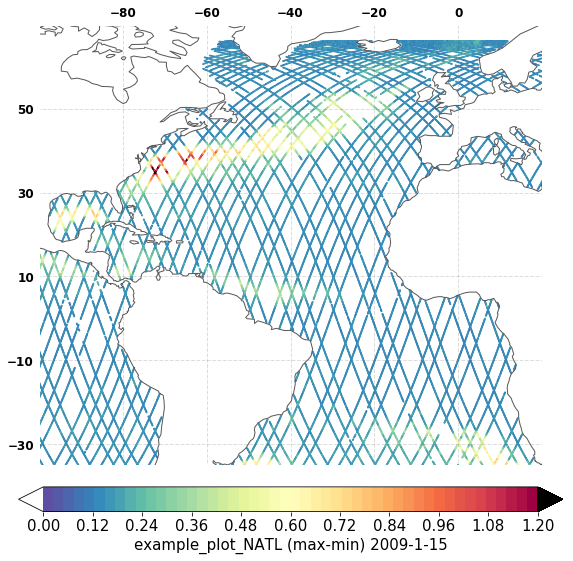

In [79]:
# select max values 
iqselect1 = 1.0
selectq1 = allquantiles.sel(q=iqselect1)
# select min values 
iqselect2 = 0.0
selectq2 = allquantiles.sel(q=iqselect2)

#------ PLOT PARAMETERS ---------------
# colormap
cm_base='Spectral_r'  

# min/max values
vmin=0
vmax=1.2
Nincr=50

# central longitude (for global map)
loncentr=180

# data to plot: 
# note: (before plotting we exclude the artefact values great/smaller than 10/-10 du to a problem in the files (coming from when the time-mean was removed))
data2plot = selectq1.where((selectq<10.)&(selectq>-10.))-selectq2.where((selectq<10.)&(selectq>-10.))
data2plot = data2plot.squeeze()

# plot title and output file title
plti="example_plot_NATL"
labelplt= plti+' (max-min) '+datena
plto = "NATL_SLA."+plti+'_'+str(DATE[0])


#create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon,lat,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=False,coastL=True,coastC=False,su='w',so='k',inonly=True) #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  


# Same as just above but global map:

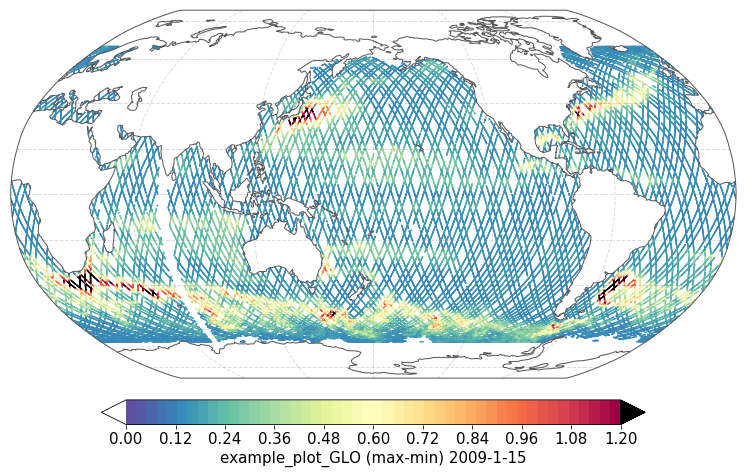

In [78]:
#------ PLOT PARAMETERS ---------------
# colormap
cm_base='Spectral_r'  

# min/max values
vmin=0
vmax=1.2
Nincr=50

# central longitude (for global map)
loncentr=180




# plot title and output file title
plti="example_plot_GLO"
labelplt= plti+' (max-min) '+datena
plto = "GLO_SLA."+plti+'_'+str(DATE[0])


#create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon,lat,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=True,loncentr=loncentr,coastL=True,coastC=False,su='w',so='k',inonly=True) #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  